In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

In [3]:
data_path = "data"

f = open(f"{data_path}/jaw_images_mutant_with_alpha.pkl", "rb")
jaws = []

while True:
    try:
        jaws.append(pickle.load(f))
    except EOFError:
        break
f.close()

jaws[0].keys()

dict_keys(['name', 'image', 'alpha_shape', 'voxel_size'])

In [4]:
jaws[0]['alpha_shape'].keys()

dict_keys(['alpha', 'points', 'triangles', 'simplices', 'vertices', 'edges', 'path', 'tri_edges', 'length', 'area', 'volume', 'tip dist', 'len ratio', 'tip volume', 'section area'])

We only study the differences betwenn `col11` and `control`

## First measure: ratio voxels/alpha volume



In [5]:
analysis = {}
for j in tqdm(jaws):
    name = j['name'].lower()
    if 'col11' in name or 'control' in name:
#         print(name)
        analysis[name]={}
        alpha = j['alpha_shape']
        image = j['image']
        num_voxels = np.sum(image>0)
        analysis[name]['alpha_volume'] = alpha['volume']
        analysis[name]['num_voxels'] = num_voxels


  0%|          | 0/125 [00:00<?, ?it/s]

In [6]:
col11ratio = [analysis[k]['num_voxels']/analysis[k]['alpha_volume'] for k in analysis.keys() if 'col11' in k]
controlratio = [analysis[k]['num_voxels']/analysis[k]['alpha_volume'] for k in analysis.keys() if 'control' in k]
# df = pd.DataFrame()
# df['na']


Ttest_indResult(statistic=-4.971017581269978, pvalue=1.013047886456956e-05)


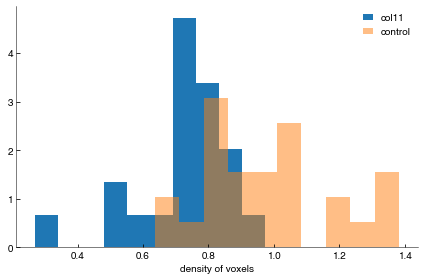

In [7]:
plt.hist(col11ratio,label='col11', density=True)
plt.hist(controlratio, alpha=0.5,label='control', density=True)
plt.legend()
plt.xlabel("density of voxels");
ttest = stats.ttest_ind(col11ratio,controlratio)
print(ttest)


## Analysing the simplexes

In [8]:
import glob
filenames = glob.glob('output/alpha*pkl')
data ={}
for f in filenames:
    data[f.lower()] = pickle.load(open(f, 'rb'))

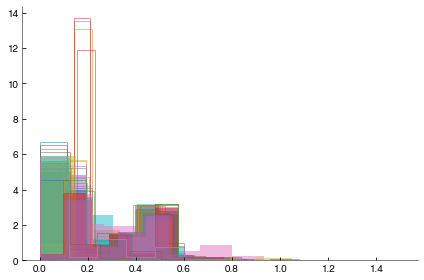

In [119]:

for key,value in data.items():
    value['avg_ratio']  = np.mean(value['ratios'])
    value['std_ratio']  = np.std(value['ratios'])
    value['ratio_max_vol'] = np.mean(
        value['ratios'][value['vols']>np.percentile(value['vols'],99.9)])
    if 'col11' in key:
        plt.hist(value['ratios'], bins=10, density=True,label=key,alpha=0.5)
    if 'control' in key:
        plt.hist(value['ratios'], bins=10, density=True,label=key,alpha=0.5, histtype='step')
# plt.legend();

In [120]:
df = pd.DataFrame()
df['control'] = ['control' in s for s in data.keys()]
df['col11'] = ['col11' in s for s in data.keys()]
df['avg_ratio'] = [value['avg_ratio'] for value in data.values()]
df['std_ratio'] = [value['std_ratio'] for value in data.values()]
df['ratio_max_vol'] = [value['ratio_max_vol'] for value in data.values()]


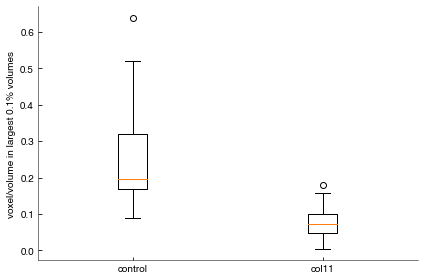

In [126]:
plt.boxplot([df[df.control==True]['ratio_max_vol'].values,
                        df[df.col11==True]['ratio_max_vol'].values ]);
plt.xticks([1,2],["control", "col11"])
plt.ylabel("voxel/volume in largest 0.1% volumes");

plt.savefig("vo_vol_control_col11.pdf")

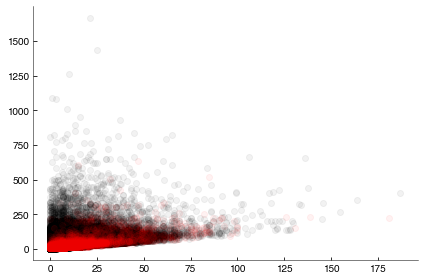

In [47]:

for key,value in data.items():
    if 'col11' in key:
        plt.plot(value['num_voxels'],value['vols'],'ok',alpha=0.05)
    if 'control' in key:
        plt.plot(value['num_voxels'], value['vols'],'or',alpha=0.05)